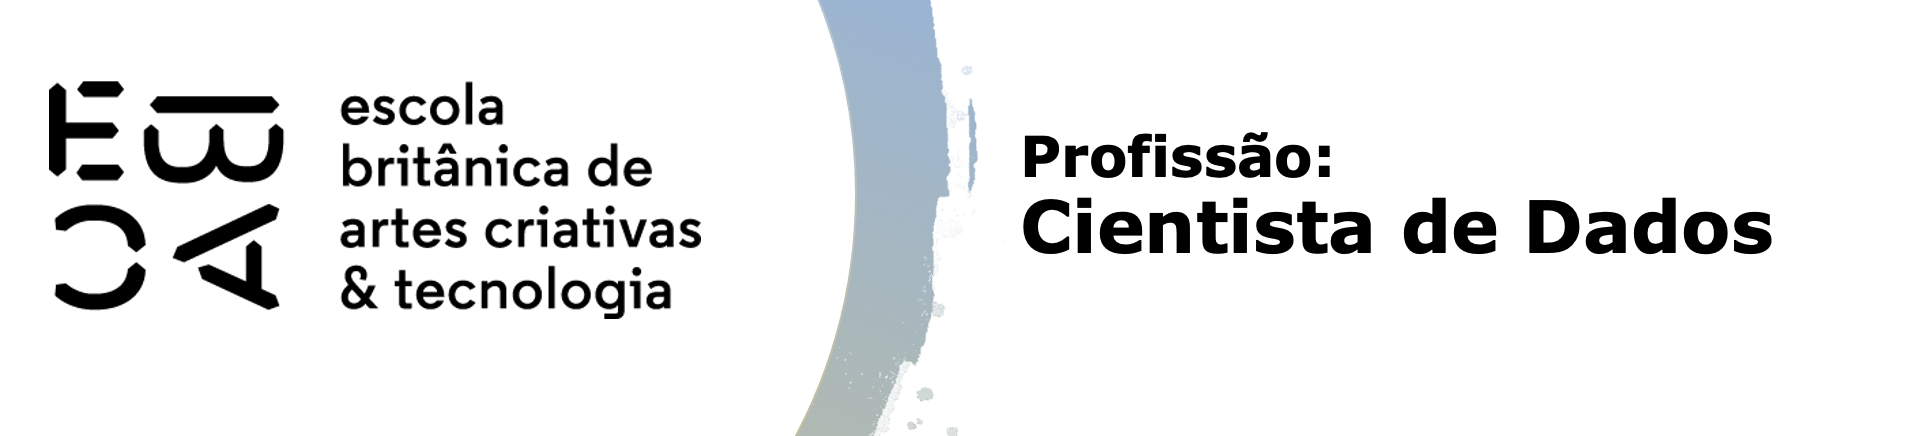

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
X_train = pd.read_csv('base_X_train.csv', sep=',')
X_test = pd.read_csv('base_X_test.csv', sep=',')

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None)

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamos acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

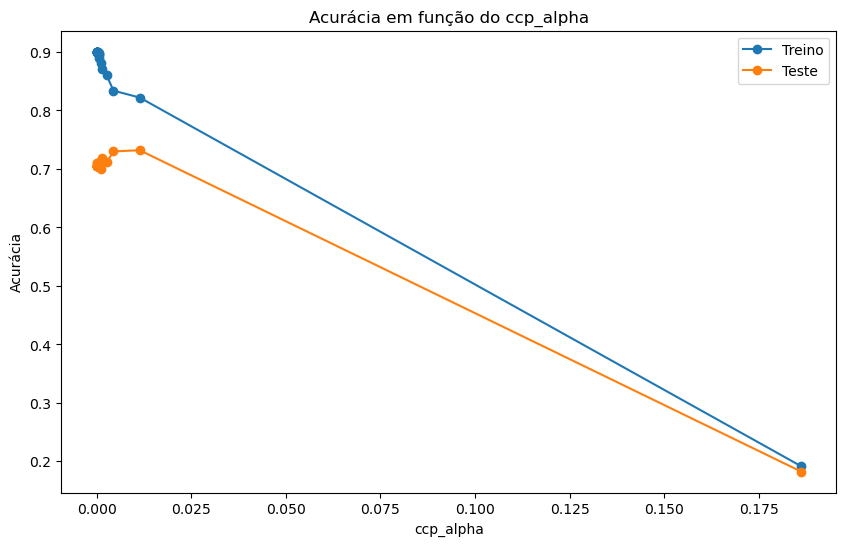

A melhor árvore tem um ccp_alpha de 0.01138
Acurácia na base de teste: 0.7319
CPU times: total: 797 ms
Wall time: 864 ms


In [4]:
%%time
# Selecionando somente as 3 melhores variáveis vistas no último exercício
X_train_selected = X_train[['tGravityAcc-min()-X', 'tBodyAccJerk-energy()-X', 'angle(Y,gravityMean)']]
X_test_selected = X_test[['tGravityAcc-min()-X', 'tBodyAccJerk-energy()-X', 'angle(Y,gravityMean)']]

# Treinamento da árvore de decisão inicial com min_samples_leaf=20
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=1000)
clf.fit(X_train_selected, y_train)

# Calcular os valores de ccp_alpha e as impurezas
path = clf.cost_complexity_pruning_path(X_train_selected, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Garantir que os ccp_alphas sejam positivos e únicos
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # Apenas valores positivos
ccp_alphas = np.unique(ccp_alphas)       # Apenas valores únicos

# Usando o slice para selecionar alguns ccp_alphas
ccp_alphas_selected = ccp_alphas[::5]

# Lista para armazenar as árvores treinadas
clfs = []

# Treinar uma árvore para cada valor de ccp_alpha selecionado
for ccp_alpha in ccp_alphas_selected:
    clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=1000, ccp_alpha=ccp_alpha)
    clf.fit(X_train_selected, y_train)
    clfs.append(clf)

# Plotar o gráfico da complexidade vs acurácia (no exemplo da base de teste)
train_scores = [clf.score(X_train_selected, y_train) for clf in clfs]
test_scores = [clf.score(X_test_selected, y_test) for clf in clfs]

melhor_arvore_idx = np.argmax(test_scores)
melhor_arvore = clfs[melhor_arvore_idx]

# Exibir a acurácia da melhor árvore

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_selected, train_scores, marker='o', label='Treino')
plt.plot(ccp_alphas_selected, test_scores, marker='o', label='Teste')
plt.xlabel("ccp_alpha")
plt.ylabel("Acurácia")
plt.title("Acurácia em função do ccp_alpha")
plt.legend()
plt.show()

print(f"A melhor árvore tem um ccp_alpha de {ccp_alphas_selected[melhor_arvore_idx]:.5f}")
print(f"Acurácia na base de teste: {test_scores[melhor_arvore_idx]:.4f}")

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [5]:
%%time
from sklearn.model_selection import GridSearchCV, KFold
# Filtrar para pegar 1 a cada 10 valores de ccp_alpha
ccp_alphas_selected = ccp_alphas[::10]  # Ajuste o valor de 10 conforme a necessidade

# Definir os parâmetros a serem testados no GridSearch
param_grid = {
    'ccp_alpha': ccp_alphas_selected,
}

# Configurar o K-Fold Cross Validation com k=10
cv = KFold(n_splits=10, shuffle=True, random_state=1000)

# Realizar o Grid Search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='accuracy')

# Ajustar o Grid Search na base de treino
grid_search.fit(X_train_selected, y_train)

# Melhor árvore encontrada
best_tree = grid_search.best_estimator_

# Exibir o melhor valor de ccp_alpha
print(f"Melhor valor de ccp_alpha: {grid_search.best_params_['ccp_alpha']}")

Melhor valor de ccp_alpha: 0.00027659672294657635
CPU times: total: 1.95 s
Wall time: 1.98 s


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia da melhor árvore na base de teste: 0.7109


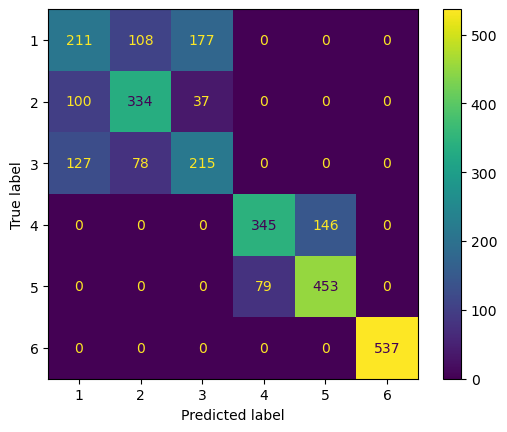

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Passo 1: Treinar a melhor árvore com a configuração encontrada em toda a base de treino
best_ccp_alpha = grid_search.best_params_['ccp_alpha']

# Reajustar a árvore usando o melhor ccp_alpha encontrado
final_tree = DecisionTreeClassifier(min_samples_leaf=20, ccp_alpha=best_ccp_alpha, random_state=1000)

# Ajustar o modelo final em toda a base de treino
final_tree.fit(X_train_selected, y_train)

# Passo 2: Calcular a acurácia na base de teste
y_test_pred = final_tree.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Acurácia da melhor árvore na base de teste: {test_accuracy:.4f}")

# Passo 3: Visualizar a matriz de confusão
ConfusionMatrixDisplay.from_estimator(final_tree, X_test_selected, y_test)


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [13]:
# Passo 1: Identificar a classe com maior erro, levando em consideração os rótulos reais
cm = confusion_matrix(y_test, y_test_pred)
errors_per_class = cm.sum(axis=1) - np.diag(cm)  # Calcula os erros por classe

# Obter o índice da classe com maior erro
classe_maior_erro = np.argmax(errors_per_class)

# Mapeando o índice para o valor real da classe
classes = np.unique(y_test)  # Obtém os rótulos reais das classes
classe_maior_erro = classes[classe_maior_erro]

print(f"Classe com maior erro: {classe_maior_erro}")

# Passo 2: Criar uma variável binária para a classe mais errada
y_train_binary = (y_train == classe_maior_erro).astype(int)
y_test_binary = (y_test == classe_maior_erro).astype(int)

# Passo 3: Ajustar uma árvore simples para prever a classe com maior erro
simple_tree = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=1000)
simple_tree.fit(X_train_selected, y_train_binary)

# Importância das variáveis
importances = simple_tree.feature_importances_
important_vars_idx = np.argsort(importances)[-3:]  # Selecionando os 3 mais importantes
important_vars = X_train_selected.columns[important_vars_idx]

print(f"Variáveis mais importantes: {important_vars}")

# Passo 4: Ajustar a árvore com as 3 novas variáveis mais importantes
X_train_expanded = X_train_selected[important_vars]
X_test_expanded = X_test_selected[important_vars]

# Rodando a árvore com as novas variáveis
expanded_tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=1000)
expanded_tree.fit(X_train_expanded, y_train)

# Avaliar o desempenho na base de teste
y_test_expanded_pred = expanded_tree.predict(X_test_expanded)
expanded_accuracy = accuracy_score(y_test, y_test_expanded_pred)

print(f"Acurácia da árvore expandida na base de teste: {expanded_accuracy:.4f}")



Classe com maior erro: 1
Variáveis mais importantes: Index(['angle(Y,gravityMean)', 'tGravityAcc-min()-X',
       'tBodyAccJerk-energy()-X'],
      dtype='object')
Acurácia da árvore expandida na base de teste: 0.7055


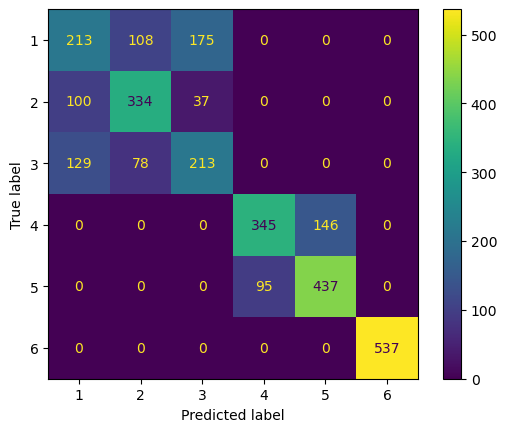

In [14]:
# Visualizando a matriz de confusão para o modelo expandido

ConfusionMatrixDisplay.from_estimator(expanded_tree, X_test_expanded, y_test)


Com as alterações somente 2 novos indivíduos da classe 1 foram corretamente classificados, porém houve uma piora nos indivíduos da classe 4 e 5. Como conclusão, a acuracidade piorou sua nota, caindo de 71,09% para 70,55%.